In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json
import sys
import re
import logging
import os
import re
from pathlib import Path
from functools import partial, cache, cached_property
from itertools import chain
from uuid import uuid4

import blpapi
import ipywidgets as w
import ipyvuetify as v
import numpy as np
import pandas as pd
import QuantLib as ql
from IPython.display import display
from ipydatagrid import DataGrid, TextRenderer, BarRenderer, Expr, VegaExpr
from bqplot import LinearScale, ColorScale, OrdinalColorScale, OrdinalScale
from pandas.tseries.offsets import BDay
from plotly import graph_objects as go
from plotly.subplots import make_subplots
from sklearn.linear_model import LinearRegression
# from bhsysapi import BHSysApi

from api.data.base import data_path, radar_path
from api.gui.params import bbg_params, spot_params, fwd_params
from api.instruments.swap import RealSwap, RollingSwap, Fly, Spread
from api.instruments.utils import parse_dates, parse_number, ez_bump
from api.instruments.future import FutureChain, FutureSpread, FutureFly, FutureStructure
from api.gui.theme import bg_color, grid_style
from api.gui.pandas import DFOutput, negative_red, custom_styler_row_line, DataGridGio

from gioutils import ezutils as ez
from gioutils.ezutils import bh, bhs
from gioutils.blpw import BlpQuery
from gioutils.gui.pandas import millify
from gioutils.utils import (
    RepeatedTimer, 
    read_history_plotter_ts,
    parse_swap_tenor_expr, 
    parse_offset,
    today, 
    get_next_n, 
    get_n_from_code,
    date_from_offset, 
    get_bday,
    get_bbg_fut_chain_ticker
)

from techi import api as ti

In [3]:
pd.options.plotting.backend = "plotly"
pd.options.display.float_format = millify

In [4]:
bq = BlpQuery(timeout=50000).start()
# ba = BHSysApi(password="A&3jg5Aj")

In [5]:
bbg_data = bq.bdh(
    securities=[
        'SFRH4 Comdty',
        'SFRH5 Comdty',
        'SFRH6 Comdty'
    ],
    fields='px_last',
    start_date='2013-01-01'
).pivot(index='date', columns='security', values='px_last')

In [10]:
bbg_data.iloc[:, [0, 2]]

security    SFRH4 Comdty  SFRH6 Comdty
date                                  
2013-01-01           NaN           NaN
2013-01-02           NaN           NaN
2013-01-03           NaN           NaN
2013-01-04           NaN           NaN
2013-01-07           NaN           NaN
...                  ...           ...
2023-03-15         96.31         96.80
2023-03-16         96.13         96.71
2023-03-17         96.43         96.94
2023-03-20         96.36         96.86
2023-03-21         96.01         96.78

[2666 rows x 2 columns]

In [342]:
data = pd.concat([bbg_data, yy], axis=1).dropna()

In [11]:
def get_df_reg(X, y, diff=False, history=None, winsor=None):
    if isinstance(X, pd.Series):
        X = X.to_frame()
    if diff:
        X = X.diff().dropna()
        y = y.diff().dropna()
    if history:
        X = X.loc[X.index[-1] - parse_offset(history):, :]
        y = y.loc[y.index[-1] - parse_offset(history):]
    df_reg = pd.concat([X, y], axis=1).ffill()
    
    if winsor:
        df_reg = pd.DataFrame(winsorize(df_reg.to_numpy(), axis=0, limits=winsor),  index=df_reg.index, columns=df_reg.columns)
    
    return df_reg

In [344]:
from scipy.stats.mstats import winsorize

In [13]:
data = bbg_data

In [47]:
df_reg = get_df_reg(
    X=data.iloc[:, 1],
    y=data.iloc[:, [0, 2]].sum(axis=1).rename('wings'),
    diff=True,
    history='1y',
    # winsor=[0.02, 0.02]
)

In [48]:
df_reg.corr()

SFRH5 Comdty   wings
SFRH5 Comdty          1.00 96.378%
wings              96.378%    1.00

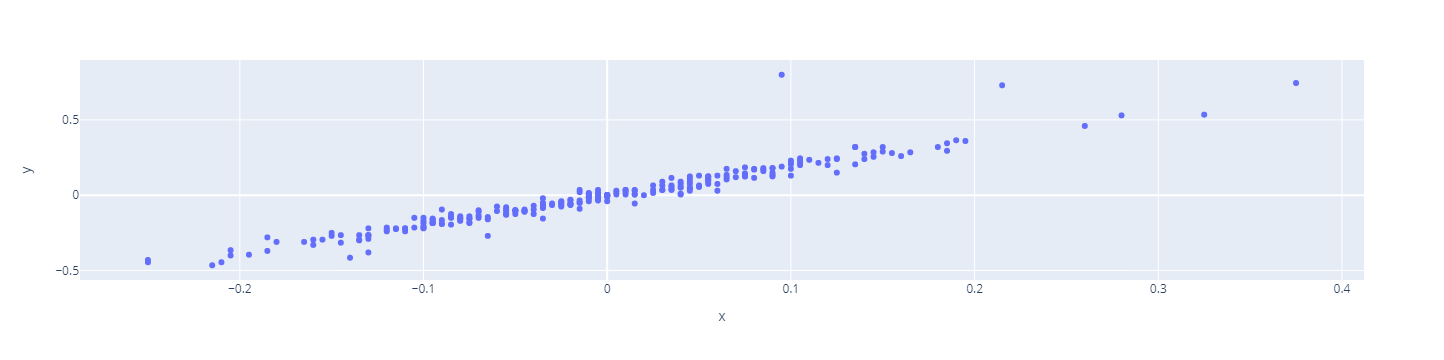

In [49]:
df_reg.plot.scatter(x=df_reg.iloc[:, 0], y=df_reg.iloc[:, 1])

In [50]:
lm = LinearRegression(fit_intercept=False)
lm.fit(df_reg.iloc[:, :-1], df_reg.iloc[:, -1]);

In [51]:
y = df_reg.iloc[:, -1].rename('y')
y_pred = pd.Series(lm.predict(df_reg.iloc [:, :-1]), index=df_reg.iloc[:, :-1].index, name='pred')

In [52]:
c = lm.coef_[0]
r2 = lm.score(df_reg.iloc[:, :-1], df_reg.iloc[:, -1])
f"params: {lm.coef_}, intercept: {lm.intercept_}, r2: {r2}"

'params: [1.95188434], intercept: 0.0, r2: 0.9287615381276312'

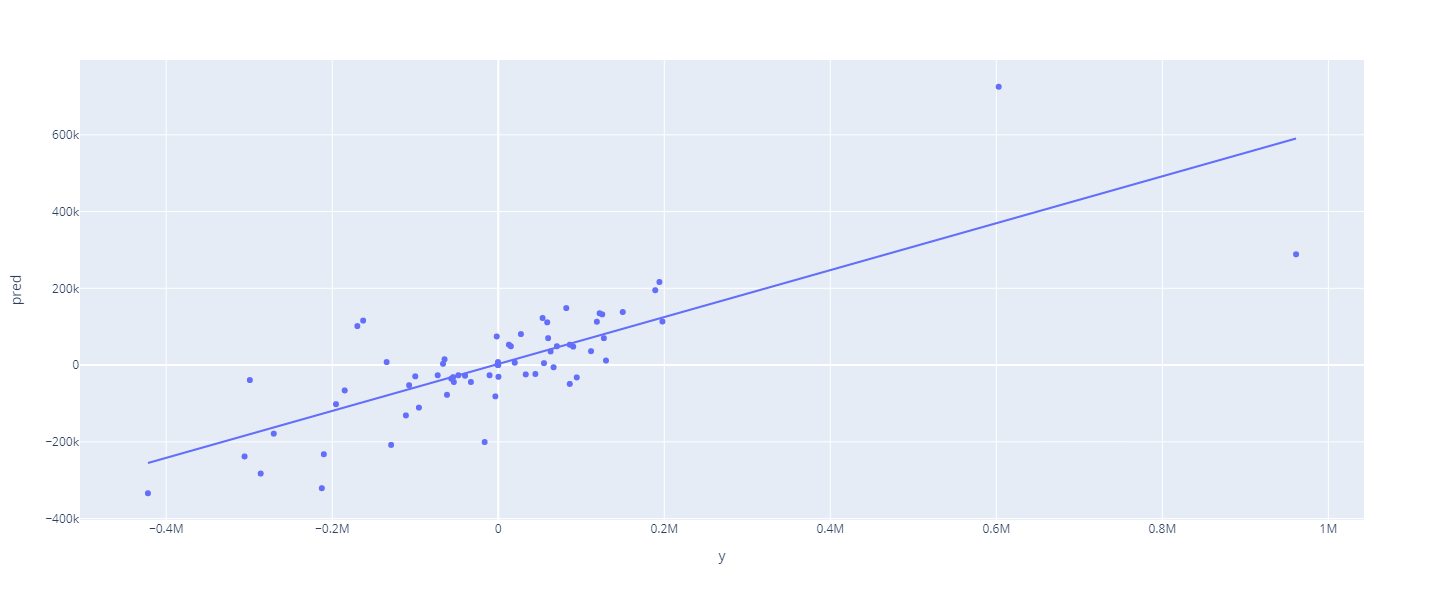

In [351]:
pd.concat([y, y_pred], axis=1).plot.scatter(x='y', y='pred', trendline="ols", height=600)

In [352]:
df_plot = df_reg.cumsum()

In [353]:
df_plot['hedge'] = df_plot.iloc[:, :df_reg.shape[1] -1] @   + lm.coef_

In [354]:
df_plot

ERU4 Comdty  ERU5 Comdty  ester_fly    hedge
date                                                    
2022-12-19       100.00        37.50   -169.71k  101.66k
2022-12-20      -100.00      -175.00    -42.47k  171.79k
2022-12-21      -225.00      -312.50    -29.61k  224.94k
2022-12-22      -362.50      -475.00     -2.28k  305.78k
2022-12-23      -500.00      -600.00     17.64k  312.04k
...                 ...          ...        ...      ...
2023-03-13      -862.50      -487.50   -238.60k -550.55k
2023-03-14       -1.37k     -1000.00   -401.34k -434.55k
2023-03-15      -625.00      -700.00    201.52k  290.61k
2023-03-16      -562.50      -662.50    264.62k  326.19k
2023-03-17      -112.50      -212.50     69.16k  224.33k

[65 rows x 4 columns]

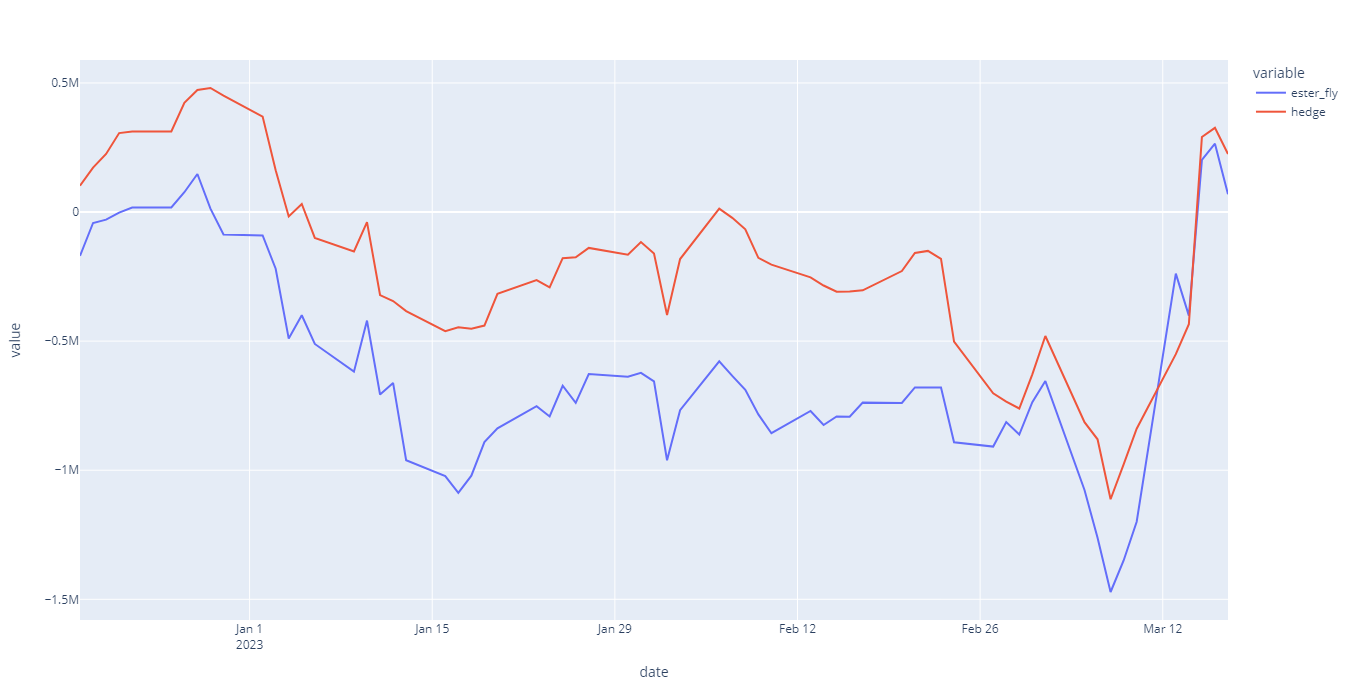

In [355]:
df_plot.iloc[:, -2:].plot(height=700)

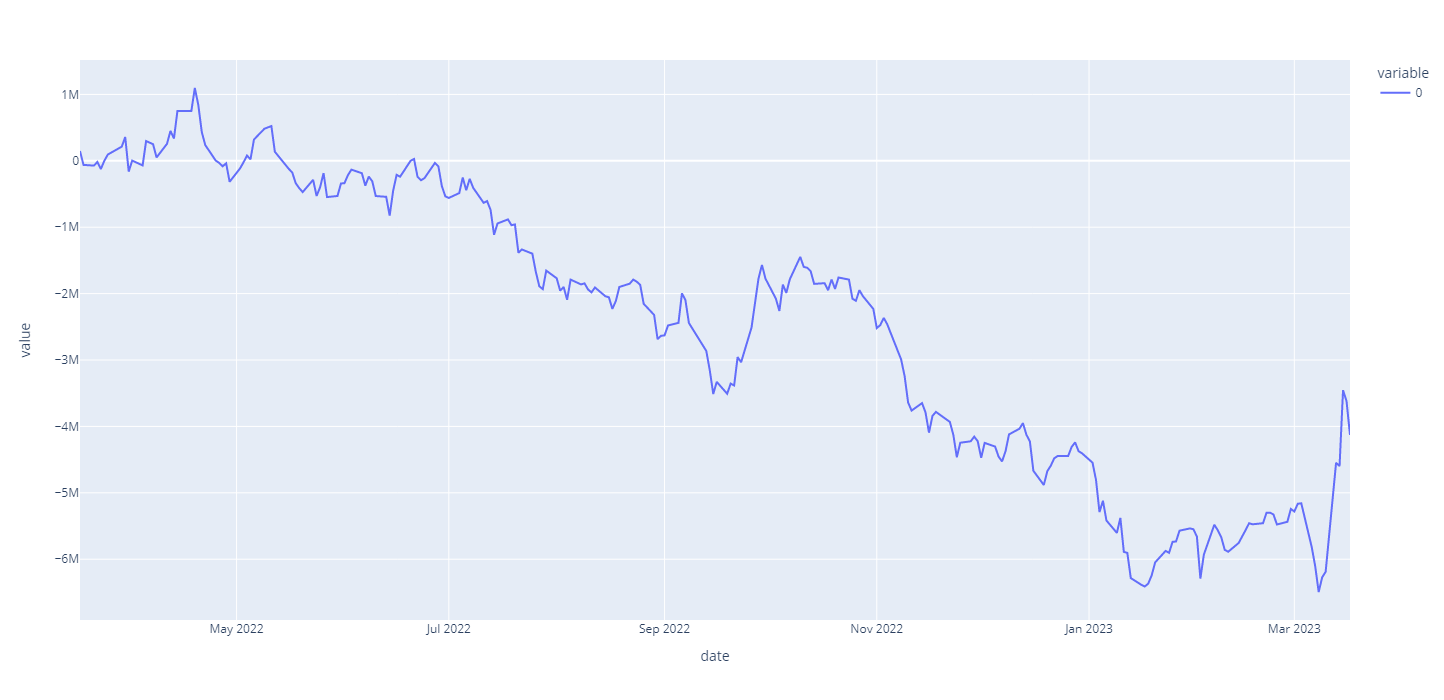

In [243]:
df_plot.iloc[:, -2:].sum(axis=1).plot(height=700)

In [ ]:
trace1

In [ ]:
trace2 = swap_rate.plot()

In [ ]:
from plotly.subplots import make_subplots

# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(
    trace1.data[0],
    secondary_y=False,
)

fig.add_trace(
    trace2.data[0],
    secondary_y=True,
)